In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold, cross_val_score, train_test_split
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_friedman1

In [248]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 30)

In [2]:
train_file = './data/train.csv'
test_file = './data/test.csv'
trainDF = pd.read_csv(train_file)
testDF = pd.read_csv(test_file)
seed = 17
pd.set_option('display.max_columns', None)

In [3]:
def doExperiment(trainInput, trainOutput, predictors, alg= LinearRegression()):
    cvMeanScore = cross_val_score(alg, trainInput.loc[:, predictors], trainOutput, cv=10, scoring='r2').mean()
    return cvMeanScore

In [4]:
def doKaggleTest(trainInput, testInput, trainOutput, testIDs, predictors):
#     alg = LinearRegression()
    alg = TweedieRegressor(power=1, alpha=0.5, link='log')
    # Train the algorithm using all the training data
    alg.fit(trainInput.loc[:, predictors], trainOutput)
    
    # Make predictions on the test set.
    predictions = alg.predict(testInput.loc[:, predictors])

    # Create a new dataframe with only the columns Kaggle wants from the dataset.
    submission = pd.DataFrame({
        "Id": testIDs,
        "SalePrice": predictions
    })

    # Prepare CSV
    submission.to_csv('data/testResults.csv', index=False)
    # Now, this .csv file can be uploaded to Kaggle

In [5]:
# BEGIN: from https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
# EXPLANATION: Define error measure for official scoring: RMSE
def rmse_cv(model, X, y, k=10):
    kf = KFold(k, shuffle=True, random_state=seed).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error", n_jobs=-1))
    return rmse
# END: from https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

In [6]:
def testModel(model, predictors):
    trainDF = pd.read_csv(train_file)
    X, y = transformData(trainDF)
    X = X.loc[:, predictors]
    print(X.head())
    cvScores = rmse_cv(model, X, y)
    print("RMSE: {:.5f} ({:.4f})".format(cvScores.mean(), cvScores.std()))

In [8]:
def transformData(trainDF):
    preprocess(trainDF, trainDF)
    dropOutliers(trainDF)  # Only for training

    y_train = trainDF['SalePrice']
    X_train = trainDF.drop(['SalePrice'], axis=1)

    X_train = standardize(X_train, X_train)
    y_train = np.log1p(y_train)
    return X_train, y_train

In [9]:
def preprocess(targetDF, sourceDF):
    handleMissingValues(targetDF, sourceDF)
    recodeValues(targetDF)
    createDummies(targetDF)
    featureEngineering(targetDF)
    dropUnusedCols(targetDF)

In [107]:
def handleMissingValues(targetDF, sourceDF):
    # replace with 0
    zero_cols = ['Utilities', 'KitchenQual', 'Functional', 'FireplaceQu', 'BsmtQual', 
                 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                 'BsmtHalfBath', 'BsmtFullBath', 'BsmtFinSF1', 'BsmtFinSF2',
                 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'GarageYrBlt', 
                 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence']
    for col in zero_cols:
        targetDF[col] = targetDF[col].fillna(0)

    # replace with median
    median_cols = ['MasVnrArea']
    for col in median_cols:
        targetDF[col] = targetDF[col].fillna(sourceDF[col].median())

In [11]:
def recodeValues(targetDF):
    targetDF['LotShape'].replace({"Reg": 3, "IR1": 2, "IR2": 1, "IR3": 0}, inplace=True)
    targetDF['LandContour'].replace({"Lvl": 3, "Bnk": 2, "HLS": 1, "Low": 0}, inplace=True)
    targetDF['Utilities'].replace({"AllPub": 3, "NoSewr": 2, "NoSeWa": 1, "ELO": 0}, inplace=True)
    targetDF['LandSlope'].replace({"Gtl": 2, "Mod": 1, "Sev": 0}, inplace=True)
    targetDF['HouseStyle'].replace({"1Story": 1, "1.5Fin": 1.25, "1.5Unf": 1.5, "2Story": 2,
                                    "2.5Fin": 2.5, "2.5Unf": 2.25, "SFoyer": 2, "SLvl": 2}, inplace=True)
    targetDF['ExterQual'].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}, inplace=True)
    targetDF['ExterCond'].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}, inplace=True)
    targetDF['BsmtQual'].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}, inplace=True)
    targetDF['BsmtCond'].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}, inplace=True)
    targetDF['BsmtExposure'].replace({"Gd": 3, "Av": 2, "Mn": 1, "No": 0}, inplace=True)
    targetDF['BsmtFinType1'].replace({"GLQ": 5, "ALQ": 4, "BLQ": 3, "Rec": 2, "LwQ": 1, "Unf": 0}, inplace=True)
    targetDF['BsmtFinType2'].replace({"GLQ": 5, "ALQ": 4, "BLQ": 3, "Rec": 2, "LwQ": 1, "Unf": 0}, inplace=True)
    targetDF['HeatingQC'].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}, inplace=True)
    targetDF['CentralAir'].replace({"Y": 1, "N": 0}, inplace=True)
    targetDF['Electrical'].replace({"SBrkr": 3, "FuseA": 2, "FuseF": 1, "FuseP": 0, "Mix": 0}, inplace=True)
    targetDF['KitchenQual'].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}, inplace=True)
    targetDF['Functional'].replace({"Sal": 7, "Sev": 6, "Maj2": 5, "Maj1": 4, 
                                    "Mod": 3, "Min2": 2, "Min1": 1, "Typ": 0}, inplace=True)
    targetDF['FireplaceQu'].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}, inplace=True)
    targetDF['GarageFinish'].replace({"Fin": 2, "RFn": 1, "Unf": 0}, inplace=True)
    targetDF['GarageQual'].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}, inplace=True)
    targetDF['GarageCond'].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}, inplace=True)
    targetDF['PavedDrive'].replace({"Y": 2, "P": 1, "N": 0}, inplace=True)
    targetDF['Fence'].replace({"GdPrv": 3, "MnPrv": 2, "GdWo": 1, "MnWw": 0}, inplace=True)

In [12]:
def createDummies(targetDF):
    cols = ['MSSubClass', 'MSZoning', 'Street','SaleCondition', 'Exterior1st']
    newDF = pd.get_dummies(targetDF, columns=cols)
    newColumns = list(set(newDF.columns) - set(targetDF.columns))
    targetDF.loc[:, newColumns] = newDF.loc[:, newColumns]

In [13]:
def featureEngineering(targetDF):
    ## Indicator variable for adjacent to or within 200 of either arterial street, feeder street, or railroad
    artery = ['Artery', 'Feedr', 'RRNn', 'RRAn', 'RRNe', 'RRAe']
    targetDF['NearArtery'] = targetDF['Condition1'].map(lambda v: 1 if v in artery else 0)
    
    ## Recode YearBuilt to YearsOld and DecadesOld 
    newestYearBuilt = 2010
    targetDF['YearsOld'] = targetDF['YearBuilt'].map(lambda v: newestYearBuilt - v)
    targetDF.loc[:, 'DecadesOld'] = targetDF.loc[:, 'YearsOld'].map(lambda v: v // 10)
    
    ## Create new features as a combination of existing features
    # BEGIN: from https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
    # EXPLANATION: New featureas by combining existing features
    targetDF["AllSF"] = targetDF["GrLivArea"] + targetDF["TotalBsmtSF"]
    # END: from from https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
   
    '''
    ## Log transformation
    # BEGIN: from https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
    # EXPLANATION: Log transformation of the skewed numberical features to lessen impact of outliers
    numerical_features = targetDF.select_dtypes(exclude = ["object"]).columns
    numerical_features = numerical_features.drop("SalePrice")
    target_num = targetDF[numerical_features]
    skewness = target_num.apply(lambda x: stats.skew(x))  # ATTENTION: this should use sourceDF after preprocessed
    skewness = skewness[abs(skewness) > 1.0]
    print(str(skewness.shape[0]) + " skewed numerical features to log transform")
    skewed_features = skewness.index
    targetDF[skewed_features] = np.log1p(targetDF[skewed_features])
    # END from: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
    '''

In [14]:
def dropUnusedCols(targetDF):
    replaced_cols = ['MSSubClass', 'MSZoning', 'Street', 'Condition1', 'Condition2', 
                     'SaleCondition', 'Exterior1st', 'YearBuilt']
    missing_cols = ['Alley', 'PoolQC', 'MiscFeature', 'FireplaceQu', 'LotFrontage']
    unused_cols = ['LotConfig', 'Neighborhood', 'BldgType', 'RoofStyle', 'RoofMatl', 
                   'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'GarageType', 
                   'SaleType']
    drop_cols = missing_cols + replaced_cols + unused_cols
    targetDF.drop(columns=drop_cols, inplace=True)

In [15]:
def dropOutliers(df):
    # Delete an obs with Electrical missing
    df.drop(df.loc[df.loc[:, 'Electrical'].isna()].index, inplace=True)
    # Delete two outliers in terms of GrLivArea 
    GrLivArea_outliers = df.sort_values(by = 'GrLivArea', ascending = False)[:2].index
    df = df.drop(GrLivArea_outliers, inplace=True)

In [16]:
def standardize(targetDF, sourceDF, cols=None):
    if cols:
        mean = sourceDF.loc[:, cols].mean()
        std = sourceDF.loc[:, cols].std()
        standardizedDF = (targetDF.loc[:, cols] - mean)/std
    else:
        mean = sourceDF.loc[:, :].mean()
        std = sourceDF.loc[:, :].std()
        standardizedDF = (targetDF.loc[:, :] - mean)/std
    return standardizedDF

In [ ]:
def main():
    # Read the original data files
    trainDF = pd.read_csv("data/train.csv")
    testDF = pd.read_csv("data/test.csv")

#     demonstrateHelpers(trainDF)
    alg = TweedieRegressor(power=1, alpha=0.5, link='log')
    trainInput, testInput, trainOutput, testIDs, predictors = transformData(trainDF, testDF)
    cvMeanScore = doExperiment(trainInput, trainOutput, predictors, alg)
    print("CV Average Score:", cvMeanScore)    
    doKaggleTest(trainInput, testInput, trainOutput, testIDs, predictors)

# main()

In [241]:
np.logspace(-6, 6, 13)

array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])

,GrLivArea,GrLivArea-sq
0,1710,41.352146
1,1262,35.524639
2,1786,42.261093
3,1717,41.436699
4,2198,46.882833


(-0.5, 9.5, 0.0, 800000.0)

(-0.5, 9.5, 10.0, 14.0)

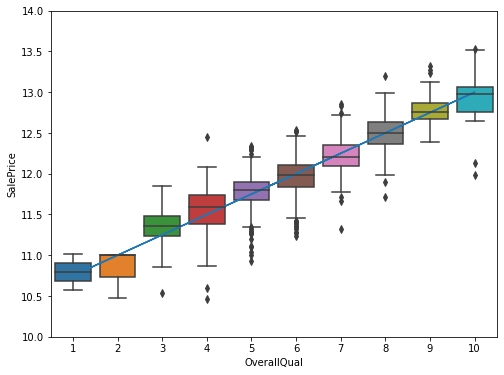

In [240]:
df_train = pd.read_csv(train_file)
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])
df_train['GrLivArea-sq'] = df_train['GrLivArea']**0.5
# df_train.loc[:, ['GrLivArea', 'GrLivArea-sq']].head()
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
x = df_train[var]
plt.plot(x-1, (2.25/9)*x+10.5)
fig.axis(ymin=0, ymax=800000)
fig.axis(ymin=10, ymax=14)

,1stFlrSF,2ndFlrSF,3SsnPorch,AllSF,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,DecadesOld,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Fence,Fireplaces,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageYrBlt,GrLivArea,HalfBath,HeatingQC,HouseStyle,Id,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MasVnrArea,MiscVal,MoSold,NearArtery,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice,ScreenPorch,Street_Grvl,Street_Pave,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YearsOld,YrSold
0,-0.689693,-0.794891,-0.116299,NaN,-1.062101,NaN,NaN,0.053410,0.604086,NaN,NaN,-0.819684,-0.240978,NaN,-0.672692,NaN,NaN,NaN,-0.359202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.950901,-1.025689,NaN,1.202124,-1.026506,NaN,NaN,NaN,-0.709047,-1.178852,-0.761360,NaN,NaN,1.732644,-0.211381,NaN,NaN,NaN,0.110725,NaN,NaN,-0.120201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.572637,-0.087658,-0.119069,NaN,-0.704242,0.381612,-0.794879,NaN,-0.068668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.882064,NaN,NaN,-0.933810,-0.399880,NaN,0.365054,NaN,-1.155984,NaN,1.644646
1,0.430364,-0.794891,-0.116299,NaN,0.163723,NaN,NaN,1.051003,-0.288554,NaN,NaN,-0.819684,-0.240978,NaN,-0.364907,NaN,NaN,NaN,-0.359202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.950901,-1.025689,NaN,-0.752930,-1.026506,NaN,NaN,NaN,-0.830555,-0.354844,1.227165,NaN,NaN,1.735016,-0.211381,NaN,NaN,NaN,0.375721,NaN,NaN,-0.120201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023830,25.107706,-0.119069,NaN,-0.160895,0.381612,-0.071812,NaN,-0.068668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.270116,NaN,NaN,-0.318574,0.619027,NaN,2.383583,NaN,-1.301294,NaN,1.644646
2,-0.606917,0.810961,-0.116299,NaN,0.163723,NaN,NaN,0.761591,-0.288554,NaN,NaN,-0.819684,-0.240978,NaN,-0.973688,NaN,NaN,NaN,-0.359202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600289,0.789470,NaN,0.042187,0.311618,NaN,NaN,NaN,0.749050,0.216062,1.227165,NaN,NaN,1.737388,-0.211381,NaN,NaN,NaN,0.331939,NaN,NaN,-0.120201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.572637,-0.087658,-1.228690,NaN,-0.191081,-0.517023,-0.794879,NaN,-0.068668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.270116,NaN,NaN,-0.318574,-0.295026,NaN,0.939497,NaN,0.636183,NaN,1.644646
3,-0.612091,0.758273,-0.116299,NaN,0.163723,NaN,NaN,0.347207,-0.288554,NaN,NaN,-0.819684,-0.240978,NaN,-0.550483,NaN,NaN,NaN,-0.359202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600289,0.789470,NaN,-0.013939,0.311618,NaN,NaN,NaN,0.789553,0.168486,1.227165,NaN,NaN,1.739759,-0.211381,NaN,NaN,NaN,-0.053984,NaN,NaN,-0.120201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.462180,-0.087658,-0.119069,NaN,-0.160895,0.381612,-0.071812,NaN,-0.068668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.270116,NaN,NaN,0.296662,-0.299585,NaN,2.120297,NaN,0.636183,NaN,1.644646
4,0.303614,-0.794891,-0.116299,NaN,-1.062101,NaN,NaN,-0.396055,-0.288554,NaN,NaN,-0.819684,-0.240978,NaN,1.017862,NaN,NaN,NaN,-0.359202,NaN,NaN,Na

<AxesSubplot:>

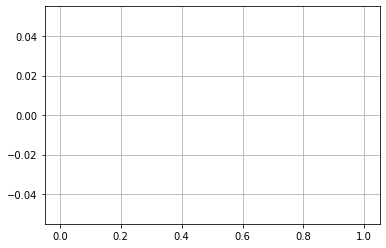

In [213]:
testDF = pd.read_csv(test_file)
trainDF = pd.read_csv(train_file)
# testDF.loc[:, ['GrLivArea', 'TotalBsmtSF']].describe()
# trainDF.loc[:, ['GrLivArea', 'TotalBsmtSF']].describe()
# trainDF['GrLivArea'].hist(bins=50)
# testDF['GrLivArea'] = np.log1p(testDF['GrLivArea'])
# testDF['GrLivArea'].hist(bins=50)

GrLivArea_outliers = trainDF.sort_values(by = 'GrLivArea', ascending = False)[:2].index
df_outliers = trainDF.iloc[GrLivArea_outliers, :]
# plt.scatter(testDF['GrLivArea'], testDF['GrLivArea'])
# plt.scatter(trainDF['GrLivArea'], trainDF['GrLivArea'])

In [221]:
predictors = ['OverallQual', 'AllSF', 'GarageCars', 'BsmtUnfSF', 'YearRemodAdd', 
              'MSZoning_RM', 'MSZoning_C (all)', 'OverallCond', 'YearsOld', 
              'Fireplaces', 'SaleCondition_Partial', 'Functional', 'SaleCondition_Normal', 
              'HeatingQC', 'NearArtery', 'LotArea', 'MSSubClass_160', 'KitchenAbvGr']

trainDF = pd.read_csv(train_file)
testDF = pd.read_csv(test_file)

dropOutliers(trainDF)
# YYY = trainDF['SalePrice']
y_train = trainDF['SalePrice'].values
X_train = trainDF.drop(["SalePrice", "Id"], axis=1)
testIds = testDF['Id']
X_test = testDF.drop(['Id'], axis=1)

n_train = trainDF.shape[0]
all_data = pd.concat(objs=[X_train, X_test], axis=0)

preprocess(all_data, all_data)

all_data.drop(['MSSubClass_150'], axis=1, inplace=True)

X_train = all_data.iloc[:n_train, :].copy()
X_test = all_data.iloc[n_train:, :].copy()

X_test = standardize(X_test, X_train)
X_train = standardize(X_train, X_train)

X_test['AllSF'] = X_test['AllSF'].map(lambda v: v  if v < 4 else 0)

# X_train.loc[X_train['AllSF'] > 3]
# X_train['AllSF'].hist(bins=50)

# X_test.loc[X_test['AllSF'] > 3]
# X_test['AllSF'].hist(bins=50)

y_train = np.log1p(y_train)

model = LinearRegression()
score = rmse_cv(model, X_train[predictors], y_train).mean()
print(f'RMSE: {score}')
model.fit(X_train[predictors], y_train)
print(f'Coeffs: {model.coef_}')
log_preds = model.predict(X_test[predictors])
predictions = np.expm1(log_preds)
print(f'Predictions: {predictions}')
pred_series = pd.Series(predictions)
pred_series[pred_series < 0].head()

# coefs = pd.Series(model.coef_, index = X_train[predictors].columns)
# imp_coefs = pd.concat([coefs.sort_values().head(10),
#                      coefs.sort_values().tail(10)])
# imp_coefs.plot(kind = "barh")
# plt.title("Coefficients in the Model")
# plt.show()

# # s = pd.Series(predictions).map(np.isinf)
# s.any()
# pred_series = pd.Series(predictions)
# expensives = pred_series.map(lambda v: v > 1000000)
# expensives[expensives].index
# outlierID = 1089
# X_test.iloc[outlierID, :].loc[predictors]
# testDF.iloc[outlierID, :].loc[['GrLivArea', 'TotalBsmtSF']]
# pred_series.hist(bins=50)
# YYY.hist(bins=50)

RMSE: 0.11664692634473503


LinearRegression()

Coeffs: [ 0.09708727  0.19735726  0.04993124 -0.05054618  0.02195686 -0.02784897
 -0.02989017  0.04398949 -0.0506822   0.02289147  0.04001804 -0.02309582
  0.02494893  0.02132315 -0.01790124  0.01982676 -0.01374308 -0.01200438]
Predictions: [112973.74724654 157345.99085787 178628.53227288 ... 173728.12309218
 115645.30610974 243728.21988424]


Series([], dtype: float64)

In [137]:
def forwardSelection():
    trainDF = pd.read_csv("data/train.csv")
#     trainDF = trainDF.loc[trainDF.loc[:, 'SalePrice'] > 339806]
#     testDF = pd.read_csv("data/test.csv")
    originalTrainDf = trainDF.copy()
    preprocessAllColumns(trainDF, originalTrainDf)
    numericAttrs = getNumericAttrs(trainDF)
    nonnumericAttrs = getNonNumericAttrs(trainDF)
#     print("Attributes with missing values:", getAttrsWithMissingValues(trainDF), sep='\n')
#     print("Numeric attributes:", numericAttrs)
#     print("Non-numeric attributes:", nonnumericAttrs)
    possibleAttrs = list(numericAttrs)
    possibleAttrs.remove('Id')
    possibleAttrs.remove('SalePrice')
    trainDF.loc[:, possibleAttrs] = standardize(trainDF, trainDF, possibleAttrs)
    predictors = ['OverallQual']
    possibleAttrs.remove('OverallQual')
    i = 0
    maxScore = -1
    maxAttr = ''
#     alg = Ridge(alpha=0.5)
    alg = TweedieRegressor(power=1, alpha=0.5, link='log')
#     alg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
#                                     max_depth=1, random_state=0, loss='ls')
    while i < 15:
        for attr in possibleAttrs:
            tmp_predictors = predictors.copy()
            tmp_predictors.append(attr)       
            trainInput = trainDF
            trainOutput = trainDF.loc[:, 'SalePrice']
            score = doExperiment(trainInput, trainOutput, tmp_predictors, alg)
            if score > maxScore:
                maxScore = score
                maxAttr = attr
        predictors.append(maxAttr)
        possibleAttrs.remove(maxAttr)
        print(f'{predictors}: {maxScore}')
        i += 1;

In [ ]:
forwardSelection()

In [ ]:
def plotHistOfSalePrice(df):
    salePrices = df.loc[:, 'SalePrice']
    print(salePrices.describe())
    # salePrices.hist(bins=50)
    sns.distplot(salePrices, fit=stats.norm)
plotHistOfSalePrice(trainDF)

In [ ]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([trainDF['SalePrice'], trainDF[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

In [ ]:
def checkCorr(df, k=10):
    # BEGIN: from from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
    # EXPLANATION: Visualization of correlation between SalePrice and k highly correlated elements
    corrmat = df.corr().abs()  # ADDED (.abs())
    color = plt.get_cmap('RdPu')  # ADDED
        
#     f, ax = plt.subplots(figsize=(12, 9))
#     sns.set(font_scale=0.7)
#     sns.heatmap(corrmat, cmap="RdPu", vmax=.8, square=True);
#     plt.show()
    
    f, ax = plt.subplots(figsize=(12, 9))
    cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
    cm = np.corrcoef(df[cols].values.T)
    sns.set(font_scale=1.0)
    hm = sns.heatmap(cm, cmap=color, cbar=True, annot=True, square=True, 
                     fmt='.2f', annot_kws={'size': 10}, vmin=0.2, vmax=0.8,
                     yticklabels=cols.values, xticklabels=cols.values)
    plt.show()
    # END: from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

In [ ]:
# checkCorr(trainDF, k=11)

pre_df = trainDF.copy()
preprocessAllColumns(pre_df, trainDF)
checkCorr(pre_df, k=16)

# std_df = standardize(pre_df, pre_df)
# checkCorr(std_df, k=11)

In [ ]:
def pairplots(df):
    sns.set()
    sns.pairplot(df, height = 2.5)
    plt.show()

In [ ]:
cols = ["SalePrice", "OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "GarageCars", "BsmtQual", "1stFlrSF", "FullBath", "GarageFinish", "YearsOld"]
pairplots(pre_df.loc[:, cols])

In [244]:
def checkMissingValues(df):
    # BEGIN: from from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
    # EXPLANATION: Caclulate the number and percentage of missing values and diplay
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data.loc[missing_data['Total'] !=0])
    # END: from from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python


In [ ]:
checkMissingValues(trainDF)
checkMissingValues(testDF)
checkMissingValues(pre_df)

In [249]:
trainDf = pd.read_csv(train_file).drop('SalePrice', axis=1)
testDF = pd.read_csv(test_file)
all_data = pd.concat(objs=[trainDf, testDF], axis=0)
# all_data.describe()
checkMissingValues(all_data)

             Total   Percent
PoolQC        2909  0.996574
MiscFeature   2814  0.964029
Alley         2721  0.932169
Fence         2348  0.804385
FireplaceQu   1420  0.486468
...            ...       ...
TotalBsmtSF      1  0.000343
Exterior2nd      1  0.000343
Exterior1st      1  0.000343
GarageArea       1  0.000343
Electrical       1  0.000343

[34 rows x 2 columns]


In [ ]:
plt.scatter(trainDF['LogGrLivArea'], trainDF['LogSalePrice'])

In [ ]:
def calcCorr(df, col1, col2):
    return df.loc[:, col1].corr(df.loc[:, col2])

In [ ]:
calcCorr(trainDF, 'LogSalePrice', 'LogGrLivArea')